# ODE based approximation of the Laplace transform
## High-order MGFs
[Previous section](2.2.Sympy%20automation.Skew%20Normal%20Distribution.ipynb)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as scsp
from scipy.special import lambertw
from scipy.integrate import odeint
from IPython.display import display, Math
import sympy as sp
plt.style.use('seaborn-v0_8-darkgrid')

In [2]:
%run -i main_funcs.py

### Even more automation

This section we explore the family of MGF:
$$\mathcal{M}_n(z)=\exp\left(\sum_{k=1}^np_k\frac{z^k}{k}\right),\,\,\,n=2...\infty.$$
We refer $n$ as MGF order.

To use the high order MGF we need to get rid of manually programming ODE. Let's Sympy create the functions for us. First of all we needs indexed variables.

In [3]:
def indexed_varf(v): 
    '''
    returns the funtion returnig indexed variable v
    '''
    return lambda i:sp.symbols(v+f'_{i}')


In [4]:
p_indexed=indexed_varf('p')
p_indexed(2)

Define the MGF genegration function

In [5]:
def gen_MGF(var,k):
    '''
    generates MGF of order n
    '''    
    poly=var(k)*z/k;
    for i in range(k-1,0,-1):
        poly += var(i)/i
        poly *= z
    return sp.exp(sp.expand(poly))  

In [6]:
MGF5=gen_MGF(p_indexed,5)
MGF5

Function to produce lists is convinient

In [7]:
def gen_list(func,order,start_from=1):
    '''
    list of func values
    '''
    return [func(i) for i in range(start_from,order+1)] 

In [8]:
gen_list(CMgenerator(RMgenerator(MGF5)),5)

The equations can be written using either central moments or raw moments. The result would be the same. For low-order MGF (2 or 3), the equations in the central moments are more simple, yet for higher-order MGF, we can get more simple equations if we use raw moments. That's why, from now on, we will be using raw moments.

At the initial moments ($t=0$) all $p_i$ except $p_2=v$ must be $0$ (we consider only the situation when $\mu=p_1(0)=0$ see Introduction).
To get an initial conditions of the differential equations system  it is nessesary to find initial values for the moments. 

In [9]:
def get_initial_momentsF(order):
    '''
    returns a function returning initial moments for given v
    '''
    p_indexed=indexed_varf('p')
    MGF=gen_MGF(p_indexed,order)
    f=sp.lambdify([gen_list(p_indexed,order)],gen_list(RMgenerator(MGF),order))
    def IM(v):
        ini_pars=np.zeros(order)
        ini_pars[1]=v
        return f(ini_pars)
    return IM

In [10]:
raw_initial_moments=get_initial_momentsF(5)(1.5)
raw_initial_moments

Inside the integration function, the moments have to be converted back to the parameters. It appears more stable to do it in two steps: first, covert raw moments to central, and second, deduce the parameters from the central moments.

First things thist 

In [11]:
def raw2centralF(order):
    '''
    returns a function converting raw moments to central
    '''
    indexed_R=indexed_varf('R')
    return sp.lambdify([gen_list(indexed_R,order)],gen_list(CMgenerator(indexed_R),order))

In [12]:
central_initial_moments=raw2centralF(5)(raw_initial_moments)
central_initial_moments

Central moments to parameters conversion

In [13]:
def central2parsF(order):
    '''
    returns a function returning params for given central moments
    '''
    indexed_p=indexed_varf('p')
    indexed_C=indexed_varf('C')
    mf=CMgenerator(RMgenerator(gen_MGF(indexed_p,order)))
    di=sp.solve([(mf(i+1)-indexed_C(i+1)) for i in range(order)], gen_list(indexed_p,order), dict=True)[0]
    return sp.lambdify([gen_list(indexed_C,order)],[sp.simplify(di[indexed_p(i+1)]) for i in range(order)])


In [14]:
central2parsF(5)(central_initial_moments)

Last, but not least, the moments derivatives from the parameters

In [15]:
def pars2Dm(order):
    indexed_p=indexed_varf('p')
    mf=DRMgenerator(gen_MGF(indexed_p,order)) 
    return sp.lambdify([gen_list(indexed_p,order)],gen_list(mf,order,start_from=0))

Everything is now prepared to develop a process that yields the approximation function for the Laplace transform. You might ask: What is the purpose of a function that returns a function? The symbolic computations required to create the system take a long time for Sympy to perform; hence, they are only performed once and are captured by the function that is returned.

In [16]:
def LaplTrLNApprFuncFactory(order):
    '''
    for given order creates a function for the producing the Laplace transform approximation 
    '''
    #it takes a long time for sympy to make all the nessesary symbolic computation
    #to produce the system, so they executed once and cuptured by resulting function
    imf=get_initial_momentsF(order)
    r2c=raw2centralF(order)
    c2p=central2parsF(order)
    p2Dm=pars2Dm(order)
    def LT_LN_ODE_Appr(u,v):# u must start from 0
        def ode(r,t):
            c=r2c(r[1:])# raw to central moments
            p=c2p(c) # central moments to parameters
            Dr=p2Dm(p)  #parameters to raw moments derivatives
            return Dr
        L=odeint(ode,np.r_[0.0,imf(v)],u).T[0] #we need to prepend 0 for L initial value
        return np.exp(L)
    return LT_LN_ODE_Appr


Let's check how fast it produced the functions

In [17]:
import time as tm

In [18]:
min_order=2
max_order=7
LaplTrLNApproximations=[None for i in range(max_order+1)]
for order in range(min_order,max_order+1):
    ct=tm.time()
    LaplTrLNApproximations[order]=LaplTrLNApprFuncFactory(order)
    print(f'Order {order}. Sympy calculations take {tm.time()-ct} s.')

Order 2. Sympy calculations take 0.254626989364624 s.
Order 3. Sympy calculations take 0.6995196342468262 s.
Order 4. Sympy calculations take 2.2829108238220215 s.
Order 5. Sympy calculations take 8.377483606338501 s.
Order 6. Sympy calculations take 34.62131690979004 s.
Order 7. Sympy calculations take 146.51132774353027 s.


Now we can see the results

In [19]:
modeling_period=500.0
u_step=0.05
u_r=np.arange(0.0, modeling_period+u_step, u_step,dtype=np.float64)
v0=1.25

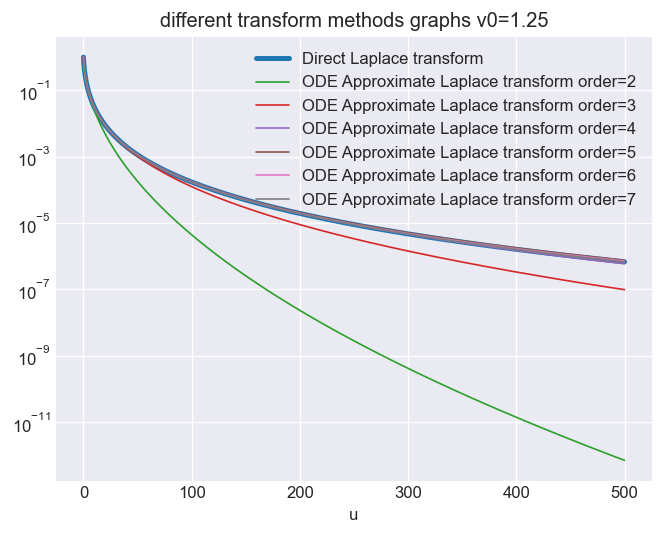

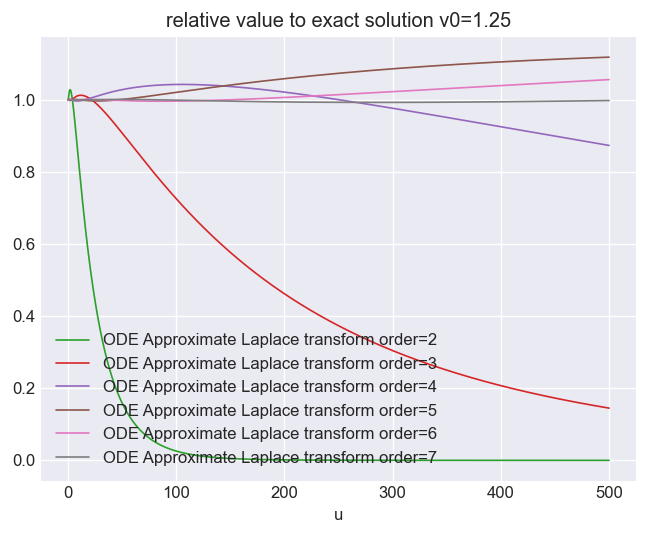

In [20]:
direct=LaplTrLNFastD(u_r,v0)
fig, ax = plt.subplots(dpi=120)
plt.title(f'different transform methods graphs v0={v0}')

plt.plot(u_r,direct, linewidth=3, color='C0', label=f'Direct Laplace transform')

for order in range(min_order,max_order+1):
    plt.plot(u_r,LaplTrLNApproximations[order](u_r,v0),linewidth=1, color=f'C{order}', 
             label=f'ODE Approximate Laplace transform order={order}')

plt.xlabel('u')
plt.yscale('log')
plt.legend(loc='upper right')
plt.show()

fig, ax = plt.subplots(dpi=120)
plt.title(f'relative value to exact solution v0={v0}')
for order in range(min_order,max_order+1):
    plt.plot(u_r,LaplTrLNApproximations[order](u_r,v0)/direct,linewidth=1, color=f'C{order}', 
             label=f'ODE Approximate Laplace transform order={order}')

plt.xlabel('u')
plt.legend(loc='lower left')
plt.show()

How fast are these functions?

In [21]:
for i in range(min_order,max_order+1):
    print(f'Order is {i}')
    %timeit LaplTrLNApproximations[i](u_r,v0)

Order is 2
6.63 ms ± 80.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Order is 3
12.8 ms ± 99.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Order is 4
26.3 ms ± 82.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Order is 5
49.7 ms ± 584 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Order is 6
90.4 ms ± 151 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Order is 7
160 ms ± 1.61 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


The functions above is created by sympy and probably not very efficient. Below manually crafted function of 5 order.

In [22]:
def LaplTrLNApproximation5(u,v0):# ODE for order 5 MGF 
    def ode(y,t):
        _,m,v,p,q,r=y
        p = 0.5*p 
        v2=v*v
        q = (q - 3*v2)/6.0
        r = (r - 20*p*v)/24.0
        s=v+p+q+r
        s2=s*s
        s3=s2*s
        q2,r2=q*q,r*r
        dL=-np.exp(m+0.5*v+p/3.0+0.25*q+0.2*r)
        dm=dL*s
        w=2.*p + 3.*q + 4.*r
        dv=dL*(w + s2)
        dp=dL*(6*q + 12*r + s3 + 3*s*w)
        w += q + 2*r
        dq=dL*(6*p*q + 12*p*r + 9*q2 + 30*q*r + 24*r2 + 24*r + s2*s2 + 6*s3 + 
                3*s2*w + 3*s*(4*p + 14*q + 24*r))
        dr=dL*(40*p*p + 120*p*q + 200*p*r + 120*q2 + 420*q*r + 360*r2 + s3*s2 + 
                10*s2*s2 + 5*s3*w + 5*s2*(16*p + 30*q + 48*r) + 
                5*s*(9*q2 + 6*q*(p + 5*r + 2) + 12*r*(p + 2*r + 4)))
        return [dL,dm,dv,dp,dq,dr]
    L=odeint(ode,[0.0,0.0,v0,0,3*v0*v0,0],u).T[0]
    return np.exp(L)

In [23]:
%timeit LaplTrLNApproximation5(u_r,v0)

13.3 ms ± 108 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


So, the overhead for automatically created functions is around 3-4 times.

And direct integration takes

In [24]:
%timeit LaplTrLNFastD(u_r,v0)

92.5 ms ± 942 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


What about even higher order 8,9,10... It seems it takes too long for sympy to create nessesary functions. To overcome this we can do numeric series expansion of $\mathcal{M}_n(z)$ up to n-th terms around 0 and 1.

For example, if we have a series s with n terms, the n terms of the Taylor series $\exp(s)-1$ is given by the fuction:

In [25]:
def exp_of_seq(s):#series first coef must be zero
    '''
    for given series s calculates
    the same length series exp(s)-1
    
    exp(s)-1=s+s^2/2!+s^3/3!+...
    '''
    l=len(s)
    summ,term=s,s
    for i in range(2,l):
        term = np.convolve(term,s)[:l]/i #t==s^i/i!
        summ = summ+term
    return summ

Let's test it

In [26]:
series_coefs=np.arange(5)
series_coefs #coefs for the series z+2z^2+3z^3+4z^4

array([0, 1, 2, 3, 4])

In [27]:
series_poly=sp.Poly(np.flip(series_coefs),z).as_expr()
series_poly

In [28]:
res_series=sp.series(sp.exp(series_poly)-1,z,n=5)
res_series

In [29]:
res_series*24

In [30]:
exp_of_seq(series_coefs)*24

array([  0.,  24.,  60., 124., 241.])

For given MGF
$$\mathcal{M}(z,u)=\exp\left(\sum_{i=1}^n\frac{p_i(u)}{i}z^i\right)$$
of order $n$, the formula for the moments' derivatives is
$$\frac{dm_k}{du}=M(u)m_k(u)-{}^k\!M(u)=\mathcal{M}(1,u)\frac{d^k\mathcal{M}}{dz^k}(0,u)-\frac{d^k\mathcal{M}}{dz^k}(1,u)$$
We omit $u$ for simplicity
$$\frac{d^k\mathcal{M}}{dz^k}(z_0)=k!\operatorname{TS}_k[\mathcal{M}(z_0+z)]$$
where $\operatorname{TS}[\mathcal{M}(z)]$ is the Taylor series expansion of $\mathcal{M}(z)$ around $0$ and $\operatorname{TS}_k[\mathcal{M}]$ is its $k$ order term coefficient.

Let $Q=\sum_{i=1}^n{q_i}z^i=\sum_{i=1}^n\frac{p_i}{i}z^i$ so
$$\mathcal{M}(z)=e^{Q(z)}$$

$$\frac{dm_k}{du}=\mathcal{M}(1)\frac{d^k\mathcal{M}}{dz^k}(0)-\frac{d^k\mathcal{M}}{dz^k}(1)=k!\left(e^{Q(1)}\operatorname{TS}_k[e^{Q(z)}]-\operatorname{TS}_k[e^{Q(1+z)}]\right)$$
taking into account
$$e^{Q(1+z)}=e^{Q(1)+Q(1+z)-Q(1)}=e^{Q(1)}e^{Q(1+z)-Q(1)}$$
we have
$$\frac{dm_k}{du}=k!e^{Q(1)}\operatorname{TS}_k[e^{Q(z)}-e^{Q(1+z)-Q(1)}]$$


The series for the $Q(1+z)-Q(1)$ can be found using binomial coefficients matrix.
$$Q(1+z)-Q(1)=\sum_{i=1}^nq_i(1+z)^i-\sum_{i=1}^nq_i=\sum_{i=1}^nq_i\sum_{j=1}^nC^i_jz^j=\mathbf{z}^TC^T\mathbf{q},$$
where $\mathbf{z}=[z,z^2,z^3...z^n]$,$\mathbf{q}=[q,q_2,q_3...q_n]^T$ and $C$ is the matrix of binomial coefficients $C^i_j$:
$$C^i_j= \begin{cases} \binom{i}{j} & j\le i, \\ 0 &\text{otherwise}. \end{cases}$$


In [31]:
def gen_binom_matrT(n):
    '''
    returns transposed binomial coefficients matrix with first row set to zero 
    '''
    coefficients = np.zeros((n + 1, n + 1),dtype=np.double)
    coefficients[:, 0] = 1.0
    for i in range(1, n + 1):
        coefficients[i, 1:i+1] = coefficients[i-1, :i] + coefficients[i-1, 1:i+1]
    coefficients[:, 0] = 0.0    
    return coefficients[1:,:].T

In [32]:
bm=gen_binom_matrT(4)
bm

array([[0., 0., 0., 0.],
       [1., 2., 3., 4.],
       [0., 1., 3., 6.],
       [0., 0., 1., 4.],
       [0., 0., 0., 1.]])

Checking the matrix multiplication produces correct result

In [33]:
sp.series(series_poly.subs(z,x+1)-series_poly.subs(z,1),x,n=5)

In [34]:
np.dot(bm,series_coefs[1:])

array([ 0., 30., 35., 19.,  4.])

Assembling all the parts 

In [35]:
def pars2Dm2(order):
    bm=gen_binom_matrT(order)
    coefs=np.ones(order)
    for i in range(order):coefs[i] /= i+1
    factorials=scsp.factorial(np.arange(order+1))
    q0=np.zeros(order+1)
    def resf(pars):
        q=coefs*pars
        q0[1:]=q
        r=(exp_of_seq(q0)-exp_of_seq(np.dot(bm,q)))*factorials
        r[0]=-1
        return np.exp(np.sum(q))*r
    return resf

def LaplTrLNApprFuncFactory(order):
    '''
    for given order creates a function for the producing the Laplace transform approximation 
    '''
    #it takes a long time for sympy to make all the nessesary symbolic computation
    #to produce the system, so they executed once and cuptured by resulting function
    imf=get_initial_momentsF(order)
    r2c=raw2centralF(order)
    c2p=central2parsF(order)
    p2Dm=pars2Dm(order) if order<6 else pars2Dm2(order) #for low order use sympy calculations
    def LT_LN_ODE_Appr(u,v):# u must start from 0
        def ode(r,t):
            c=r2c(r[1:])# raw to central moments
            p=c2p(c) # central moments to parameters
            Dr=p2Dm(p)  #parameters to raw moments derivatives
            return Dr
        L=odeint(ode,np.r_[0.0,imf(v)],u).T[0] #we need to prepend 0 for L initial value
        return np.exp(L)
    return LT_LN_ODE_Appr

In [36]:
min_order=5
max_order=10
LaplTrLNApproximations=[None for i in range(max_order+1)]
for order in range(min_order,max_order+1):
    ct=tm.time()
    LaplTrLNApproximations[order]=LaplTrLNApprFuncFactory(order)
    print(f'Order {order}. Calculations take {tm.time()-ct} s.')

Order 5. Calculations take 5.384810209274292 s.
Order 6. Calculations take 1.602147102355957 s.
Order 7. Calculations take 3.4371700286865234 s.
Order 8. Calculations take 8.771077156066895 s.
Order 9. Calculations take 19.456515550613403 s.
Order 10. Calculations take 45.71070599555969 s.


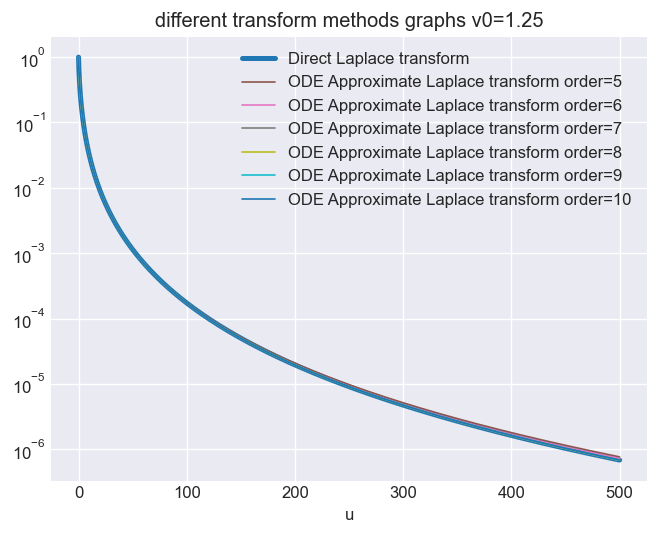

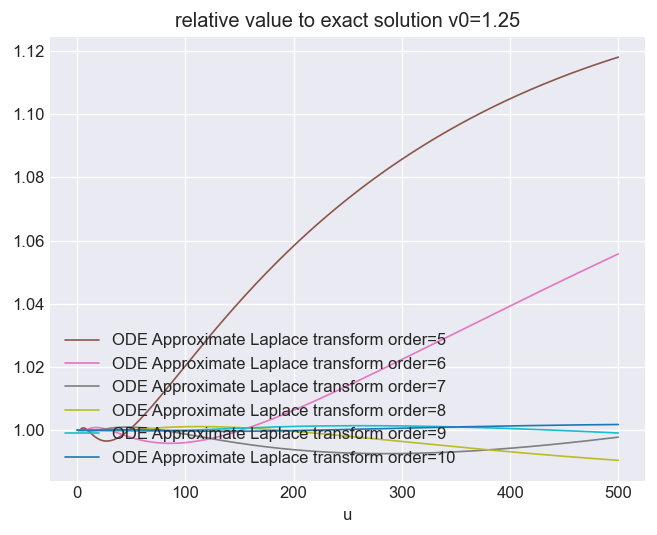

In [37]:
direct=LaplTrLNFastD(u_r,v0)
fig, ax = plt.subplots(dpi=120)
plt.title(f'different transform methods graphs v0={v0}')

plt.plot(u_r,direct, linewidth=3, color='C0', label=f'Direct Laplace transform')

for order in range(min_order,max_order+1):
    plt.plot(u_r,LaplTrLNApproximations[order](u_r,v0),linewidth=1, color=f'C{order}', 
             label=f'ODE Approximate Laplace transform order={order}')

plt.xlabel('u')
plt.yscale('log')
plt.legend(loc='upper right')
plt.show()

fig, ax = plt.subplots(dpi=120)
plt.title(f'relative value to exact solution v0={v0}')
for order in range(min_order,max_order+1):
    plt.plot(u_r,LaplTrLNApproximations[order](u_r,v0)/direct,linewidth=1, color=f'C{order}', 
             label=f'ODE Approximate Laplace transform order={order}')

plt.xlabel('u')
plt.legend(loc='lower left')
plt.show()

In [38]:
for i in range(min_order,max_order+1):
    print(f'Order is {i}')
    %timeit LaplTrLNApproximations[i](u_r,v0)

Order is 5
49.2 ms ± 154 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Order is 6
98 ms ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Order is 7
120 ms ± 1.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Order is 8
145 ms ± 7.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Order is 9
171 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Order is 10
199 ms ± 1.24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Parameterless approach

Can we do all the stuff without using the distribution parameters $p_1,...,p_n$. Well... let us see.

Once again $X \sim LogN(\mu,v)$ - lognormally distributed variable, $Y=\ln(X) \sim N(\mu,v)$ its normally distributed counterpats and we assume for simplicity $\mu=0$. The Laplace transform of X is:
$$\mathcal{L}(u)=\operatorname{E}\! \left[e^{-Xu} \right]=\operatorname{E}\! \left[e^{-e^Yu} \right]$$

Let
$$g(u,y)=\exp\left(-e^yu\right)f_Y(y)$$
$$g_i(u)=\int_{-\infty}^{\infty}y^i\exp\left(-e^yu\right)f_Y(y)dy$$
$$q_i(u)=\frac{dg_i}{du}=-\int_{-\infty}^{\infty}y^ie^y\exp\left(-e^yu\right)f_Y(y)dy$$
where $f_Y(y)$ the PDF of the Y. 

We introduce new random variable $Z$ by norming $g$, so PDF for the Z is:
$$f_Z(z)=\frac{g(u,z)}{\mathcal{L}(u)}=\frac{g(u,z)}{g_0(u)}.$$
Now raw moments of Z can be expessed as:
$$m_i=\operatorname{E}[Z^i]=\frac{g_i(u)}{g_0(u)},$$
also

$$\frac{q_i}{g_0}=\frac{1}{g_0}\frac{dg_i}{du}=-\operatorname{E}[Z^ie^Z].$$
Let we denote $\operatorname{E}[Z^ie^Z]$ as ${}^i\!M$, and now
$$\frac{dm_i}{du}=\frac{d}{du}\left(\frac{g_i}{g_0}\right)=\frac{q_ig_0-q_0g_i}{g_0^2}=m_i\operatorname{E}[e^Z]-\operatorname{E}[Z^ie^Z]=m_i{}^0\!M-{}^i\!M.$$

It can be proved, that 
$$\frac{\ln(\mathcal{L}(u))}{du}=-\operatorname{E}[e^Z]=-{}^0\!M,$$
indeed
$$\frac{\ln(\mathcal{L}(u))}{du}=\frac{1}{\mathcal{L}}\frac{d\mathcal{L}}{du}=\frac{1}{g_0}\frac{dg_0}{du}=\frac{q_0}{g_0}=-\operatorname{E}[e^Z]$$
Last step, we need to express $\operatorname{E}[Z^ie^Z]$
$$\operatorname{E}[Z^ie^Z]=\sum_{k=0}^\infty\frac{1}{k!}\operatorname{E}[Z^{i+k}]=\sum_{k=0}^\infty\frac{m_{k+i}}{k!}$$
If we denote $\ln(\mathcal{L})$ as $L$ we would get infinite system
$$\frac{dL}{du}=-\sum_{k=0}^\infty\frac{m_{k}}{k!}$$
$$\frac{dm_i}{du}=\sum_{k=0}^\infty\frac{m_{i}m_{k}-m_{k+i}}{k!}, i=1..\infty$$
$$m_i(0)=m_i(\mu,v)$$
where $m_i(\mu,v)$ is i-th raw moment of the normal distribution $N(\mu,v)$.

To get approximate solution we can try to set $m_i=0$ for $i$ bigger than some value $n$. Is it working? Rather no.


In [39]:
def LaplTrLNApprF(order):
    '''
    for given order creates a function for the producing the Laplace transform approximation 
    '''
    def gen_exp_matr(order):
        n=order+1
        co = np.zeros((n, n),dtype=np.double)
        fc=1./scsp.factorial(np.arange(1,n+1))
        for i in range( n ):
            co[i, i:] = fc[:n-i]
        return co
    def get_initial_m(order):
        p_indexed=indexed_varf('p')
        MGF=gen_MGF(p_indexed,2)
        f=sp.lambdify([gen_list(p_indexed,order)],gen_list(RMgenerator(MGF),order))
        def IM(v):
            ini_pars=np.zeros(order)
            ini_pars[1]=v
            return f(ini_pars)
        return IM
    imf=get_initial_m(order)
    mat=gen_exp_matr(order)
    def LT_LN_ODE_Appr(u,v):# u must start from 0
        def ode(m,t):
            m[0]=1.
            em=np.dot(mat,m)
            m[0]=0.
            Dm=em[0]*m-em
            return Dm
        L=odeint(ode,np.r_[0.0,imf(v)],u).T[0] #we need to prepend 0 for L initial value
        return np.exp(L)
    return LT_LN_ODE_Appr

In [40]:
min_order=5
max_order=7
LaplTrLNApproximations=[None for i in range(max_order+1)]
for order in range(min_order,max_order+1):
    ct=tm.time()
    LaplTrLNApproximations[order]=LaplTrLNApprF(order)
    print(f'Order {order}. Calculations take {tm.time()-ct} s.')

Order 5. Calculations take 0.1035311222076416 s.
Order 6. Calculations take 0.08673381805419922 s.
Order 7. Calculations take 0.07981729507446289 s.


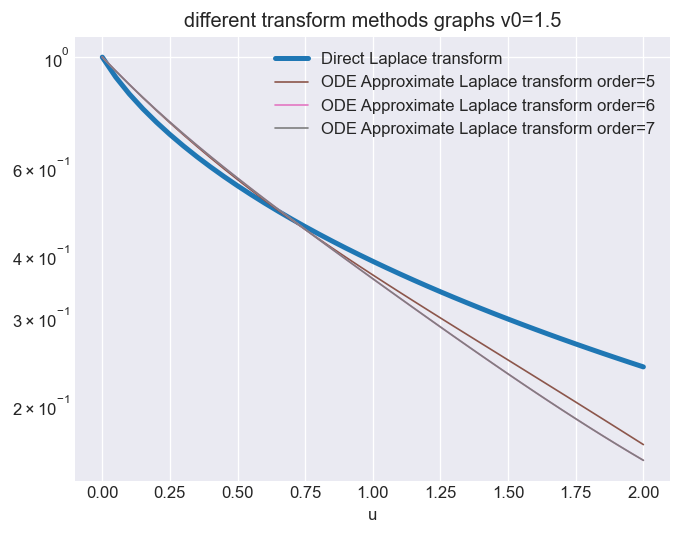

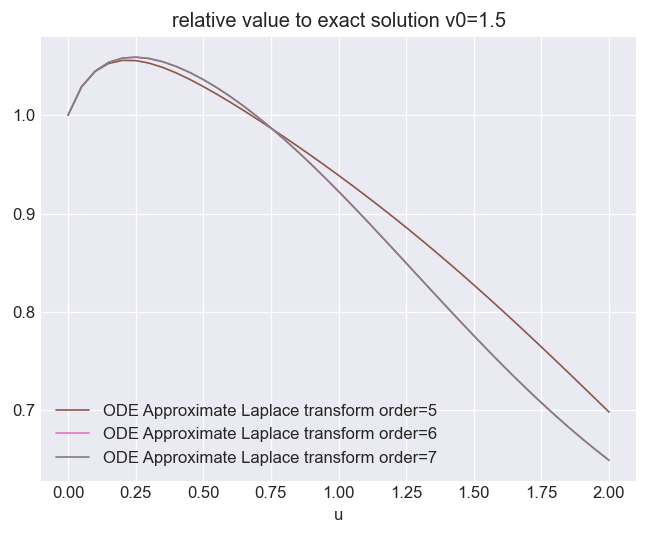

In [41]:
modeling_period=2.0
u_step=0.05
u_r=np.arange(0.0, modeling_period+u_step, u_step,dtype=np.float64)
v0=1.5
direct=LaplTrLNFastD(u_r,v0)
fig, ax = plt.subplots(dpi=120)
plt.title(f'different transform methods graphs v0={v0}')

plt.plot(u_r,direct, linewidth=3, color='C0', label=f'Direct Laplace transform')

for order in range(min_order,max_order+1):
    plt.plot(u_r,LaplTrLNApproximations[order](u_r,v0),linewidth=1, color=f'C{order}', 
             label=f'ODE Approximate Laplace transform order={order}')

plt.xlabel('u')
plt.yscale('log')
plt.legend(loc='upper right')
plt.show()

fig, ax = plt.subplots(dpi=120)
plt.title(f'relative value to exact solution v0={v0}')
for order in range(min_order,max_order+1):
    plt.plot(u_r,LaplTrLNApproximations[order](u_r,v0)/direct,linewidth=1, color=f'C{order}', 
             label=f'ODE Approximate Laplace transform order={order}')
plt.xlabel('u')
plt.legend(loc='lower left')
plt.show()


We can repead all for $X$ instead of $Y$

$$g'(u,x)=\exp\left(-xu\right)f_X(x)$$

$$f_{Z'}(z)=\frac{g'(u,z)}{\mathcal{L}(u)}$$

$$m_i'=\operatorname{E}[Z'^i]$$

Then, we get following system

$$\frac{dL}{du}=-m_1'$$

$$\frac{dm_i'}{du}=m_1'm_i'-m_{i+1}', i=1..\infty$$

$$m_i'(0)=m_i'(\mu,v)$$

where $m_i'(\mu,v)$ is i-th raw moment of the log normal distribution $LogN(\mu,v)$.

But, if we trancate the system for some $n$ to get the approximate solution it doesn't work at all.